# Выявление успешности игр
## Введение

В интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры, хотят выявить закономерности успешности игр. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
## Изучение исходной информации
Целью данного проекта является произвести прогнозирование маркетинговых действий по продвижению игр на 2017 год по данным за предыдущие года. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

Открываем файл с имеющимися данными и выведем первые 15 строк для оценки датафрейма

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head(15)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Датасет имеет удовлетворительное качество данных. Для упрощения обработки заменим названия столбцов строчными символами. После этого рассмотрим количество пропусков данных.

In [3]:
data.columns = data.columns.astype(str).str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Предварительный анализ датасета показывает, что имеются почти полностью заполненые разделы с объемом продажам,жанром,названием игры и платформой. Немного не хватает данных, связанных с годом выпуска игры. Данные об оценках и рейтинги заполнены наполовину, что является заметным для анализа.

## Подготовка данных

Имеется порядка 300 пропусков в графе с годом релиза. Анализ пропусков не выявил закономерности их появления. Заполнение пропусков в столбце с годом релиза медианным значением не рекомендуется, т.к. приведёт к внесению явных ложных данных в датасете. Например, FIFA Soccer 2004 очевидно была выпущена в 2003-2004 году. При заполнении медианным значением 2007 получится очевидная ошибка, которая подорвет доверие к отчету. Для заполнения порядка 120 значений из 269 неизвестных сделано предположение, что мультиплатформенные игры выходят одновременно на разных платформах. Исходя из этого одинаковым играм на разных платформах присвоен равнозначный год. Дальнейшее заполнение пустых ячеек в столбце year_of_release весьма трудоемко.


**Осторожно, длительное выполнение ячейчки!(10-15с)**

In [4]:
data['year_of_release'] = data['year_of_release'].fillna(0).astype('int')
print('Количество строк без даты выпуска до обработки', data.loc[(data['year_of_release'] == 0),'name'].count() )
true_y = data.groupby('name')['year_of_release'].max() #составляем сгрупированный список всех игр
#заполняем нулевые значения списком true_y
for t in data['name'].unique():
    if t in true_y:
        data.loc[(data['name'] == t) & (data['year_of_release']==0), 'year_of_release'] = true_y[t]
print('Количество строк без даты выпуска после обрабоки', data.loc[(data['year_of_release'] == 0),'name'].count() )

Количество строк без даты выпуска до обработки 269
Количество строк без даты выпуска после обрабоки 146


Заполнение рейтинговых данных медианными значениями неразумно, т.к. отсутствующих значений примерно половина выборки. Это окажет большое влияние на процесс исследования. Пропуски в столбцах critic_score, user_score оставлены без изменений.
Есть две игры без названия, имеющие пропуски многих столбцов и маленькие продажи. Эти игры были удалены без заметного влияния. Проверка на дубликаты показала их отсутствие. Пропуски в столбе rating заполнены значениями unknown. 

In [5]:
data['rating'] = data['rating'].fillna('unknown')
print("Количество явных дубликатов: ", data.duplicated().sum()) 
data.dropna(subset =['name'], inplace=True)

Количество явных дубликатов:  0


Пропуски значений в столбцах с оценками и рейтингом отчетливо прослеживаются для игр до 1996 года. Вероятнее всего до этого года не существовало практики выставления оценок. Поэтому имеются основания заполнить пустующие значения с рейтингами и оценками для игр до 1996 года нулями.


Столбец user_score содержит значения 'tbd', что подразумевает ожидание рейтинга. По сути это просто уточнение причины пропуска, из-за которой рейтинг отсутствует, вследствие этого эти значения также заменены на NaN и преобразованы в числовой формат для удобной обработки и ранжирования. 


Далее, рассматривая столбец rating видим, что имеются игры с категорией K-A и E, что является одной категорией. Эти оценки приведены к более современному обозначению Е.

In [6]:
#print( data.groupby('year_of_release')['rating'].count() ) проверка появления рейтингов в 1996
#data.loc[ (data['critic_score']!=data['critic_score']) & (data['year_of_release'] < 1996), 'critic_score'] = 0
data.loc[  data['user_score']=='tbd' , 'user_score'] = np.nan
data['user_score'] = data['user_score'].astype('float16')
#data.loc[ (data['rating']!=data['rating']) & (data['year_of_release'] < 1996), 'rating' ] = 0
data.loc[data['rating']=='K-A', 'rating'] = 'E'

Внесем в датафрейм новый столбец с суммой продаж по всем регионам

In [7]:
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

## Исследовательный анализ данных
### Общий анализ

Раасмотрим количество проданных игр по годам. При этом на графике ниже видно, что количество игр до 1990 года продавалось незначительно. После 1990 количество новых игр начало резко расти и достигло пика в 2008 году, после чего наметился такой же резкий спад. Наблюдается отчетливая тенденция к снижению продаж новых игр.

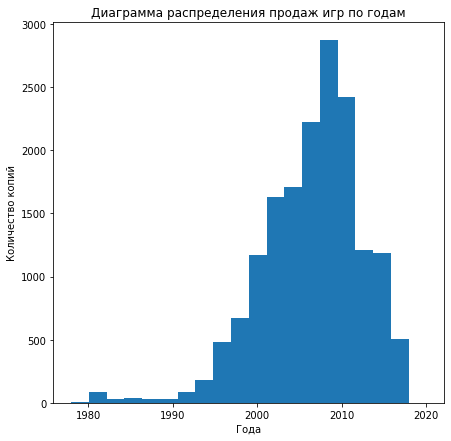

In [8]:
plt.figure(figsize=(7,7))
plt.xlabel('Года')
plt.ylabel('Количество копий')
plt.title('Диаграмма распределения продаж игр по годам')
plt.hist(data['year_of_release'],bins=20, range=[1978, 2020] );

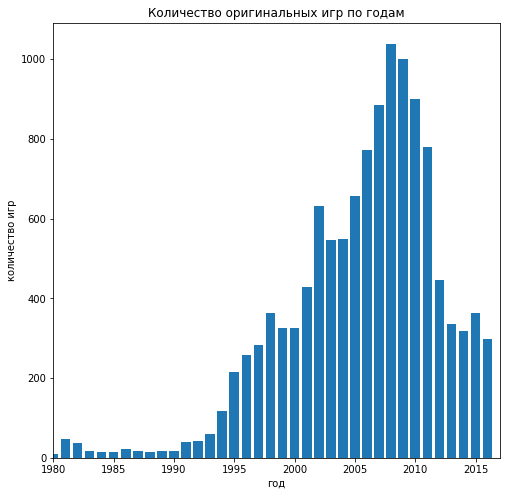

In [9]:
count_data = data.groupby('year_of_release')['name'].nunique().reset_index()
plt.figure(figsize=(8,8))
plt.xlabel('год')
plt.ylabel('количество игр')
plt.title('Количество оригинальных игр по годам')
plt.xlim(1980, 2017)
plt.bar('year_of_release', 'name', data=count_data);

График показывает количество оригинальных игр, выпущенных с 1980 по 2016 год. При этом в целом график отражает тенденции графика выше.

Рассмотрим распределение продаж игр по платформам, для котороых они выпускались.

In [10]:
print( data.pivot_table(index='platform', values='sum_sales',aggfunc='sum').sort_values('sum_sales',ascending=False))

          sum_sales
platform           
PS2         1255.77
X360         971.42
PS3          939.65
Wii          907.51
DS           806.12
PS           730.86
GBA          317.85
PS4          314.14
PSP          294.05
PC           259.52
3DS          259.00
XB           257.74
GB           255.46
NES          251.05
N64          218.68
SNES         200.04
GC           198.93
XOne         159.32
2600          96.98
WiiU          82.19
PSV           54.07
SAT           33.59
GEN           28.35
DC            15.95
SCD            1.86
NG             1.44
WS             1.42
TG16           0.16
3DO            0.10
GG             0.04
PCFX           0.03


Самые большие продажи имеют игры на платформе PS2, X360, PS3, Wii, DS и PS. 

Рассмотрим как менялись продажи электронных игр на различных платформах за всех время. 

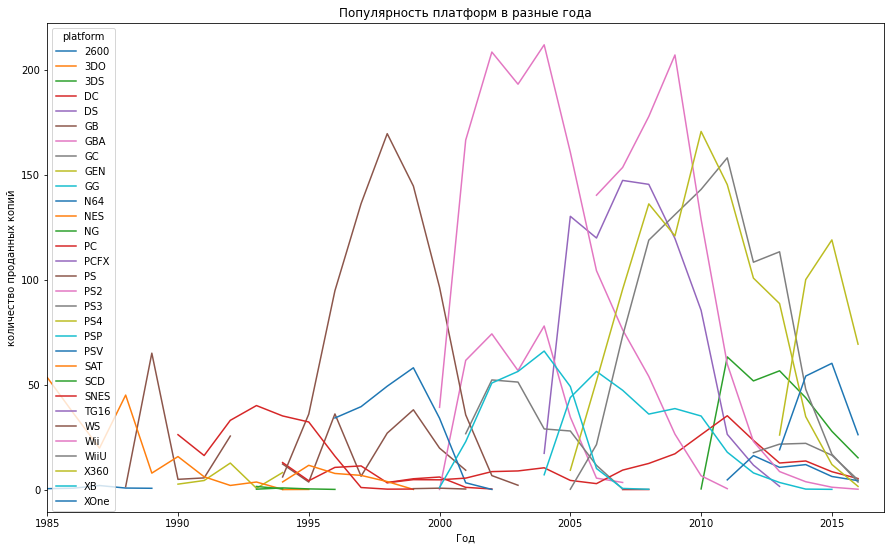

In [11]:
history_pl = data.pivot_table(index='year_of_release',columns='platform', values='sum_sales',aggfunc='sum')
history_pl.plot(kind='line',xlim = [1985,2017],figsize = [15,9] , xlabel='Год',ylabel='количество проданных копий',  
                title='Популярность платформ в разные года'  );

Построенный график показывают, что пики продаж игр были в 1997-2012. К 2015 большинство игровых платформ растеряли поклонников. Среднее время жизни платформы порядка 6-10 лет. 

Определим год, с которого считаем данные актуальными для нас. Судя по графику начиная с 2012 года тенденции становятся заметными  и достаточными для анализа. 
Создадим датафрейм с интересующими годами и оценим продажи в последнее время. 

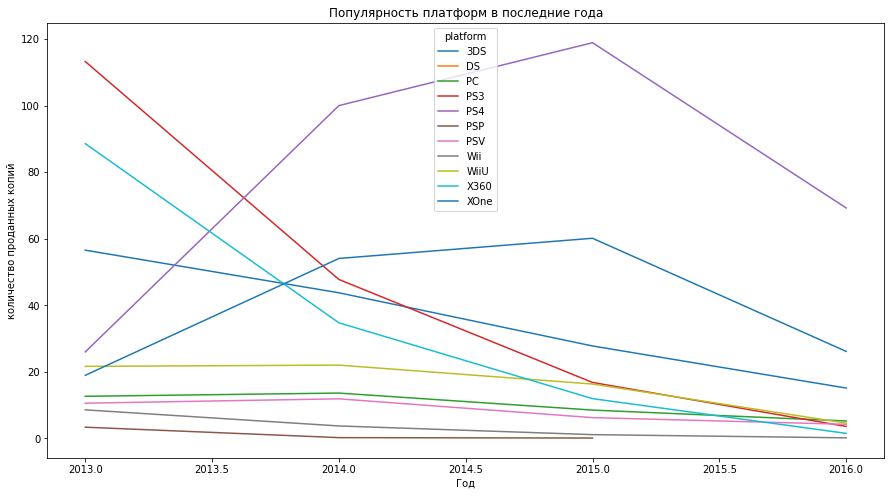

In [12]:
res_data = data.loc[data['year_of_release']>2012]
piv_data = res_data.pivot_table(index='year_of_release',columns='platform', values='sum_sales',aggfunc='sum')
piv_data.plot(kind='line',figsize = [15,8], xlabel='Год',ylabel='количество проданных копий',  
                title='Популярность платформ в последние года');

График отчетливо показывает, что продажи игр на всех платформах находятся на спаде или их продажи стабильно маленькие. Для проведения рекламных компаний следует сосредоточиться на продвижении игр для платформ Xone и PS4, однако следует осторожно относиться к продвижению, т.к. нет гарантии роста продаж. 

### Диаграммы и зависимости
Построим график типа "ящик с усами"

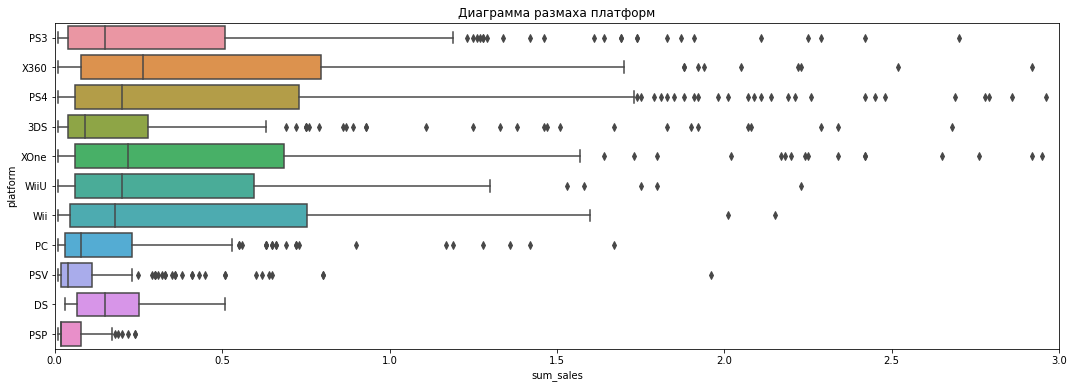

In [13]:
plt.figure(figsize=(18,6))
plt.xlim([0,3])
plt.title('Диаграмма размаха платформ')
sns.boxplot(data=res_data, x='sum_sales', y='platform'  );

In [17]:
print(res_data.groupby('platform')['sum_sales'].sum().reset_index().sort_values('sum_sales') )

   platform  sum_sales
1        DS       1.54
5       PSP       3.74
7       Wii      13.66
6       PSV      32.99
2        PC      40.06
8      WiiU      64.63
9      X360     136.80
0       3DS     143.25
10     XOne     159.32
3       PS3     181.43
4       PS4     314.14


На примере игры PS4 выявлена слабая связь между объемом продаж и критическими оценками. Связь между продажами и оценками пользователей почти отсутствует.

Построим диаграмму рассеяния связи критических оценок с объемом продаж для игр на PS4.

In [ ]:
x_c = res_data.loc[res_data['platform']=='PS4', 'critic_score']
y_c = res_data.loc[res_data['platform']=='PS4', 'sum_sales']
plt.title('Связь критических оценок с объемом продаж PS4')
sns.scatterplot(x=x_c, y=y_c);

Основная информация о продажах игр сводится к следующей фразе - игры с рейтингом менее 6.0 продаются очень плохо. Игры с рейтингом более 6.0 могут продаваться хорошо, но это редко. Игр с рейтингом более 9.0 мало, но они все имеют неплохие продажи. 

In [ ]:
x_c = res_data.loc[res_data['platform']=='PS4', 'user_score']
y_c = res_data.loc[res_data['platform']=='PS4', 'sum_sales']
plt.title('Связь пользовательских оценок с объемом продаж PS4')
sns.scatterplot(x=x_c, y=y_c);

График показывает, что только игры с оцень низким рейтингом имеют слабые продажи. В целом пользовательские оценки не влияют на продажи. Самые большие продажи имеет игра с рейтингом 8,5, а за ней следует игра с рейтингом 4,5. 

### Анализ данных X360
Рассмотрим как распределена корреляция для платформы X360

In [ ]:
res_data.loc[res_data['platform']=='X360',['sum_sales','critic_score','user_score']].corr()

Для проверки взяты результаты анализа корреляции для платформы X360. Результаты предыдущего вывода подтверждаются. 


Построим диаграмму рассеяния связи критических оценок с объемом продаж для платформы X360.

In [ ]:
x_c = res_data.loc[res_data['platform']=='X360', 'critic_score']
y_c = res_data.loc[res_data['platform']=='X360', 'sum_sales']
plt.title('Связь критических оценок с объемом продаж X360')
sns.scatterplot(x=x_c, y=y_c);

Вывод во многом повторяет полученный для платформы PS4. Игры с рейтингом менее 6.0 продаются очень плохо. Игры с рейтингом более 6.0 могут продаваться хорошо, но это редко.

Рассмотрим диаграмму рассеяния пользовательских оценок для платформы X360.

In [ ]:
x_c = res_data.loc[res_data['platform']=='X360', 'user_score']
y_c = res_data.loc[res_data['platform']=='X360', 'sum_sales']
plt.title('Связь пользовательских оценок с объемом продаж X360')
sns.scatterplot(x=x_c, y=y_c);

Вывод также соотносится с полученным ранее, за исключением одного выброса-игры с рейтингом 3. 

### Анализ данных XOne

In [ ]:
res_data.loc[res_data['platform']=='XOne',['sum_sales','critic_score','user_score']].corr()

Для дополнительной проверки взяты результаты анализа корреляции для платформы XOne. Результаты предыдущих выводов подтверждаются. 

Построим диаграмму рассеяния связи критических оценок с объемом продаж для платформы XOne.

In [ ]:
x_c = res_data.loc[res_data['platform']=='XOne', 'critic_score']
y_c = res_data.loc[res_data['platform']=='XOne', 'sum_sales']
plt.title('Связь критических оценок с объемом продаж XOne')
sns.scatterplot(x=x_c, y=y_c);

Игры с рейтингом менее 6.0 продаются очень плохо. Игры с рейтингом более 6.0 могут продаваться хорошо, но это редко.

Рассмотрим диаграмму рассеяния пользовательских оценок для платформы XOne.

In [ ]:
x_c = res_data.loc[res_data['platform']=='XOne', 'user_score']
y_c = res_data.loc[res_data['platform']=='XOne', 'sum_sales']
plt.title('Связь пользовательских оценок с объемом продаж XOne')
sns.scatterplot(x=x_c, y=y_c);

График показывает, что только игры с оцень низким рейтингом имеют слабые продажи. Пользовательские оценки не влияют на продажи. Самые большие продажи имеет игра с рейтингом 8, а за ней следует игра с рейтингом 5,5. Близкие результаты получены для платформ PS4 и X360.

Рассмотрим как распределены продажи игр по жанрам. Попробуем найти самый прибыльный жанр - такой жанр, где медианные продажи  самые высокие. Согласно отсортированного списка видно, что самым прибыльными являются игры в жанре Shooter.

In [ ]:
plt.figure(figsize=(18,6))
plt.xlim([0,1.5])
plt.title('Диаграмма размаха по жанрам')
sns.boxplot(data=res_data, x='sum_sales', y='genre'  );

In [ ]:
print('Список медианных значений продаж по жанрам\n', res_data.groupby('genre')['sum_sales'].median().sort_values(ascending=False) )

## Портрет пользователя каждого региона

Оценим данные по лидирующим платформам на трех рынках.

In [ ]:
for item in ['na_sales','eu_sales','jp_sales']:
    print(res_data.pivot_table(index='platform', values=item,aggfunc='sum')\
      .sort_values(by=item,ascending=False)\
      .reset_index()\
      .loc[0:4] , '\n')

В Северной Америке лидирует PS4, немного отстает Xone и X360. В Европе с серьезным отрывом лидирует PS4. В Японии с серьезным отрывом лидирует 3DS, втрое обгоняя PS3.

Рассмотрим распределение предпочтений по жанрам игр среди трех континентов. 

In [ ]:
for item in ['na_sales','eu_sales','jp_sales']:
    print(res_data.pivot_table(index='genre', values=item,aggfunc='sum')\
      .sort_values(by=item,ascending=False)\
      .reset_index()\
      .loc[0:4] , '\n')

Жанровые предпочтения в Северной Америке и Европе очень похожи. В Японии же наблюдаются отличия в том, что первое место занимают Role-Playing игры, а Shooter пользуются очень слабой популярностью.

Далее рассмотрим рейтинг возрастного ограничения и его связь с продажами. 

In [ ]:
for item in ['na_sales','eu_sales','jp_sales']:
    print(res_data.pivot_table(index='rating', values=item,aggfunc='sum')\
      .sort_values(by=item,ascending=False)\
      .reset_index()\
      .loc[0:4] , '\n')

"Влияет ли рейтинг ESRB на продажи в отдельном регионе?" - этот вопрос немного неккоректен, т.к. вероятнее всего не рейтинг влияет на продажи, а жанровые предпочтения, которые уже в свою очередь влияют результаты количества продаж по рейтингам ESRB. Большие продажи игр в жанре Action приводят к увеличению продаж игр с рейтингом M, что заметно по рынкам Европы и Северной Америки. Вместе с тем игры без рейтинга занимают существенную роль в продажах на японском рынке. Вероятнее всего из-за того, что много игр не представлены на рынке Америки и не получили рейтинга. 

## Проверка гипотезы

Рассмотрим сравнение средних пользовательских рейтингов платформ Xbox One и PC. Нулевая гипотеза - средние пользовательские рейтинги на Xbox One и PC равны. Альтернативная гипотеза - средние пользовательские рейтинги на Xbox One и PC не равны.

In [ ]:
sample_xb = list( res_data.dropna(subset=['user_score']).loc[data['platform']=='XOne', 'user_score']  )
sample_pc = list( res_data.dropna(subset=['user_score']).loc[data['platform']=='PC', 'user_score']  )
alpha = .05 # критический уровень статистической значимости
results = st.ttest_ind(sample_xb, sample_pc)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

При уровне статистической значимости 5% следует, что средние пользовательские рейтинги на Xbox One и PC равны.

Рассмотрим следующую задачу. Необходимо подтвердить информацию о том, что средние пользовательские рейтинги жанров Action и Sports разные.
- Нулевая гипотеза: cредние пользовательские рейтинги жанров Action и Sports равны. 
- Альтернативная гипотеза:  cредние пользовательские рейтинги жанров Action и Sports не равны.

In [ ]:
sample_ac = list(res_data.dropna(subset=['user_score']).loc[data['genre']=='Action', 'user_score']  )
sample_sp = list(res_data.dropna(subset=['user_score']).loc[data['genre']=='Sports', 'user_score']  )
alpha = .05 # критический уровень статистической значимости
results = st.ttest_ind(sample_ac, sample_sp)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

На основе результатов видно, что средние пользовательские рейтинги жанров Action и Sports не равны. Альтернативная гипотеза считается более вероятной.

Применен критерий о равенстве средних двух выборок. Для использования t-теста подходят условия его применения. 

## Вывод

В данной работе был взят для анализа большой обьем данных про продажам игр. При подготовке к анализу ряд отсутствующих значений был заполнен актуальными значениями, две нерепрезентативные строки удалены. Тип данных приведен к удобному для анализа. 

При историческом осмотре видно, что бурный рост продаж игр начался с 1996 года и достиг пика в 2008 году. За это время несколько платформ сменили друг друга. Среднее время жизни платформы: 6-10 лет. В ходе анализа становится виден основной тренд продаж игр после 2010 года - количество проданных копий снижается. Надеяться на увеличение продаж следует с большой осторожностью. При этом только на двух платформах имеются шансы получить удовлетворительные результаты продаж - XOne и PS4. 

Особо большим спросом у жителей Северной Америки и Европы пользуются игры в жанре Action и Shooter. Для жителей Японии расклад несколько другой - на первом месте с большим отрывом игры в жанре Role-Playing и Action. 

По результатам рассмотрения суммарных продаж и оценок игры сделано заключение, что имеется слабая корреляция между обьемом продаж и критическими оценками, и нулевая связь между продажами и оценками пользователей. Данный вывод сделан в результате анализа трех платформ: PS4, X360 и XOne.

Проверка гипотез показала , что средние пользовательские рейтинги на Xbox One и PC равны, а средние пользовательские рейтинги жанров Action и Sports не равны с уровнем статистической погрешности 5%. 